# Import stuff

In [1]:
#basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import functools
import inspect
import copy #--to avoid refitting model during CV

#data pre-processing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

#import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#model hyperparameter tuning/optimizing
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.feature_selection import RFE

#cross-validation
from sklearn.model_selection import cross_val_score #--for binary class

#model visualizations
from sklearn.tree import plot_tree, export_text

#performance statistics/scoring analysis
from sklearn.preprocessing import label_binarize
import sklearn.metrics as sk_metrics

from sklearn.decomposition import PCA


# LOAD DATA

In [2]:
#load in data
employee_df = pd.read_csv('Employee.csv')
employee_df

Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0     Bachelors         2017  Bangalore            3   34    Male          No   
1     Bachelors         2013       Pune            1   28  Female          No   
2     Bachelors         2014  New Delhi            3   38  Female          No   
3       Masters         2016  Bangalore            3   27    Male          No   
4       Masters         2017       Pune            3   24    Male         Yes   
...         ...          ...        ...          ...  ...     ...         ...   
4648  Bachelors         2013  Bangalore            3   26  Female          No   
4649    Masters         2013       Pune            2   37    Male          No   
4650    Masters         2018  New Delhi            3   27    Male          No   
4651  Bachelors         2012  Bangalore            3   30    Male         Yes   
4652  Bachelors         2015  Bangalore            3   33    Male         Yes   

      ExperienceInCurrentDomain  LeaveOrNot  
0                             0           0  
1                             3           1  
2                             2           0  
3                             5           1  
4                             2           1  
...                         ...         ...  
4648                          4           0  
4649                          2           1  
4650                          5           1  
4651                          2           0  
4652                          4           0  

[4653 rows x 9 columns]

In [3]:
#Given that max. JoinYear is 2018, make "LengthOfEmployment" variable
employee_df['JoiningYear'].max()

employee_df['LengthOfEmployment'] = 2018 - employee_df['JoiningYear']
employee_df.drop(columns='JoiningYear', inplace=True)

employee_df['LengthOfEmployment'].value_counts(dropna=False) 

1    1108
3     781
4     699
5     669
2     525
6     504
0     367
Name: LengthOfEmployment, dtype: int64

# DATA PREPROCESSING

Education - ordinal encode
{exclude JoiningYear}
City - OneHotEncode
PaymentTier - None, already ordinal
Gender - DummyEncode (via OneHot) (Male:1/0, infer Female)
EverBenched - OneHotEncode/Binarize
ExperienceInCurrentDomain - None, already ordinal

Age - standardize
LengthOfEmployment - standardize

In [4]:
#check for NA's
employee_df.loc[employee_df['LeaveOrNot'].isna()]

Empty DataFrame
Columns: [Education, City, PaymentTier, Age, Gender, EverBenched, ExperienceInCurrentDomain, LeaveOrNot, LengthOfEmployment]
Index: []

In [5]:
ord_ftrs = ['Education'] #'ExperienceInCurrentDomain', 'PaymentTier'
onehot_ftrs = ['City', 'EverBenched', 'Gender']
num_ftrs = ['Age', 'LengthOfEmployment']


ordinal_transformer = OrdinalEncoder(dtype='int')
onehot_transformer = OneHotEncoder(sparse_output=False, drop='first', dtype='int') #drop first category of each OneHot to avoid multi-collinearity
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


transformers = [
    ("ordinal", ordinal_transformer, ord_ftrs),
    ("onehot", onehot_transformer, onehot_ftrs),
    ("numerical", numeric_transformer, num_ftrs)
]

column_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough', verbose_feature_names_out=False)
column_transformer.set_output(transform='pandas')

employee_df = column_transformer.fit_transform(employee_df)
employee_df

Education  City_New Delhi  City_Pune  EverBenched_Yes  Gender_Male  \
0             0               0          0                0            1   
1             0               0          1                0            0   
2             0               1          0                0            0   
3             1               0          0                0            1   
4             1               0          1                1            1   
...         ...             ...        ...              ...          ...   
4648          0               0          0                0            0   
4649          1               0          1                0            1   
4650          1               1          0                0            1   
4651          0               0          0                1            1   
4652          0               0          0                1            1   

           Age  LengthOfEmployment  PaymentTier  ExperienceInCurrentDomain  \
0     0.954645           -1.039638            3                          0   
1    -0.288732            1.107233            1                          3   
2     1.783563            0.570515            3                          2   
3    -0.495961           -0.502921            3                          5   
4    -1.117650           -1.039638            3                          2   
...        ...                 ...          ...                        ...   
4648 -0.703191            1.107233            3                          4   
4649  1.576334            1.107233            2                          2   
4650 -0.495961           -1.576356            3                          5   
4651  0.125727            1.643951            3                          2   
4652  0.747416            0.033797            3                          4   

      LeaveOrNot  
0              0  
1              1  
2              0  
3              1  
4              1  
...          ...  
4648           0  
4649           1  
4650           1  
4651           0  
4652           0  

[4653 rows x 10 columns]

In [6]:
#split total response rows for training & testing model
model_training_df, model_testing_df = train_test_split(employee_df, test_size=0.2, random_state=0)

X_train = model_training_df[[l for l in model_training_df.columns if l != 'LeaveOrNot']]
Y_train = model_training_df[['LeaveOrNot']]

X_test = model_testing_df[[l for l in model_testing_df.columns if l != 'LeaveOrNot']]
Y_test = model_testing_df[['LeaveOrNot']]

# PCA Testing

Education  City_New Delhi  City_Pune  EverBenched_Yes  Gender_Male  \
0     -3.045728        0.843360   0.507784        -0.743843    -0.095678   
1      0.163292       -1.006338  -0.244473         1.658157    -1.127036   
2     -1.126989       -0.502128   1.654605         0.164263     0.455190   
3      2.124255        0.603755  -0.218078        -0.290317     0.542502   
4     -0.776721        0.960960  -1.289997        -0.256371    -0.026817   
...         ...             ...        ...              ...          ...   
4648   1.229267       -1.131701  -0.474594        -0.032651    -0.041662   
4649  -1.082241       -0.961860   1.459839         0.877576    -0.062887   
4650   2.078240        1.747634  -0.290941        -0.199811     0.955993   
4651  -0.841092       -1.722941   0.084745        -0.416082     0.112815   
4652   0.983235       -0.016278   0.906540        -0.607381    -0.039854   

           Age  LengthOfEmployment  PaymentTier  ExperienceInCurrentDomain  
0     0.075493           -0.218021    -0.200306                   0.060868  
1     0.130497           -0.297447    -0.067784                  -0.037896  
2    -0.882307           -0.015989     0.170806                  -0.437702  
3     0.502446            0.211801    -0.317514                   0.353394  
4     0.834132            0.769112     0.793040                   0.408850  
...        ...                 ...          ...                        ...  
4648 -0.649306            0.171797    -0.242641                   0.228700  
4649  1.123027            0.243035    -0.032413                  -0.022075  
4650  0.242540            0.029951     0.053230                  -0.294015  
4651  0.133865           -0.272573     0.722139                   0.566126  
4652  0.093758           -0.255129     0.690514                   0.558530  

[4653 rows x 9 columns]

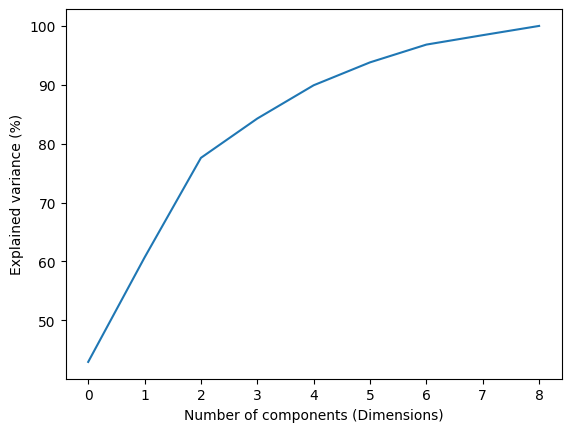

In [7]:
#PCA consideration..
pca_og = PCA()
pca_df = employee_df[[l for l in employee_df.columns if l != 'LeaveOrNot']]
pca_df_rotated = pca_og.fit_transform(pca_df)

# Make the scree plot
plt.plot(np.cumsum(pca_og.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

pd.DataFrame(pca_df_rotated, index=pca_df.index, columns=pca_df.columns)

As we can see, the explained variance of the data takes a significant hit with PCA.

Nonetheless, we can try PCA to reduce to 4 components with decent representation of original data.

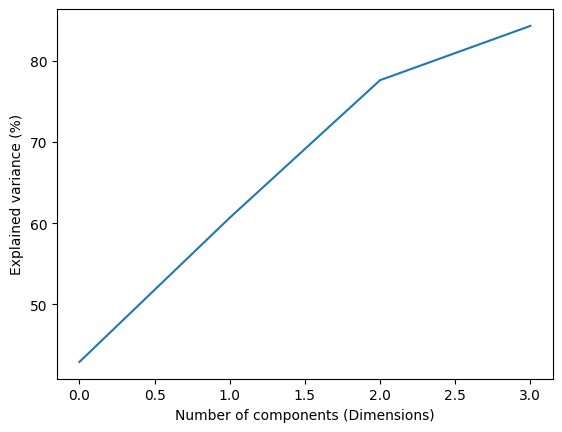

In [8]:
#PCA consideration..
pca_red = PCA(n_components=4)
pca_red.fit(pca_df)

# Make the scree plot
plt.plot(np.cumsum(pca_red.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

X_train_reduced = pd.DataFrame(pca_red.transform(X_train), index=X_train.index)

X_test_reduced = pd.DataFrame(pca_red.transform(X_test), index=X_test.index)

# INITIAL TRAIN/TEST OF LOGREG MODEL (dep)

In [9]:
#FULL MODEL TRAINING

# x = X_train.to_numpy()
# y = np.ravel(Y_train.to_numpy())

# max_iter = 100 #2000
# slv='lbfgs'

# model = LogisticRegression(solver=slv, max_iter=max_iter, random_state=0)

# #model training
# print(f"\n\nFitting model..")
# start_time = time.time()
# model.fit(x, y)
# fit_time = time.time() - start_time
# #tuning_dict['num_ftrs'] = x.shape[1]
# print(f"\nFinished fitting model. Took {fit_time}s\n\n")

# #get model predictions (evaluate trained model --validation comp. to known actual)
# start_time = time.time()
# y_pred = model.predict(x)
# pred_time = time.time() - start_time
# y_pred_proba = model.predict_proba(x) # model.classes_ -- [0, 1]

# accuracy = sk_metrics.accuracy_score(y, y_pred)
# precision = sk_metrics.precision_score(y, y_pred, average=None)
# recall = sk_metrics.recall_score(y, y_pred, average=None)
# print(f'Accuracy: {accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')

# cm = sk_metrics.confusion_matrix(y, y_pred)
# display = sk_metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
# display.plot()
# plt.show()


# 'accuracy' : sk_metrics.accuracy_score(y_actual, y_pred, sample_weight=wt),
# 'f1_macro' : sk_metrics.f1_score(y_actual, y_pred, average='macro', sample_weight=wt),
# 'f1_micro' : sk_metrics.f1_score(y_actual, y_pred, average='micro', sample_weight=wt),
# 'precision_macro' : sk_metrics.precision_score(y_actual, y_pred, average='macro', sample_weight=wt),
# 'precision_micro' : sk_metrics.precision_score(y_actual, y_pred, average='micro', sample_weight=wt),
# 'recall_macro' : sk_metrics.recall_score(y_actual, y_pred, average='macro', sample_weight=wt),
# 'recall_micro' : sk_metrics.recall_score(y_actual, y_pred, average='micro', sample_weight=wt),
# 'jaccard_macro' : sk_metrics.jaccard_score(y_actual, y_pred, average='macro', sample_weight=wt),
# 'jaccard_micro' : sk_metrics.jaccard_score(y_actual, y_pred, average='micro', sample_weight=wt),

In [10]:
#MODEL TESTING

# x = X_test.to_numpy()
# y = np.ravel(Y_test.to_numpy())

# start_time = time.time()
# #predict y based on x
# y_pred = model.predict(x)
# pred_time = time.time() - start_time

# #compute predicted probability distributions
# y_pred_proba = model.predict_proba(x)

# accuracy = sk_metrics.accuracy_score(y, y_pred)
# precision = sk_metrics.precision_score(y, y_pred, average=None)
# recall = sk_metrics.recall_score(y, y_pred, average=None)
# print(f'Accuracy: {accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')

# cm = sk_metrics.confusion_matrix(y, y_pred)
# display = sk_metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
# display.plot()
# plt.show()

# PRIMARY MODEL CREATION/EVAL FUNCS

In [11]:
def Decorator_Make_Model(init_func):
    signature = inspect.signature(init_func)
    default_kwargs = { kw: val.default for kw, val in signature.parameters.items() if val.default != inspect.Signature.empty }
    
    @functools.wraps(init_func)
    #Create model
    def wrapper(*args, **kwargs):
        kwargs = default_kwargs | kwargs
        print(f"\n>>BEGIN Initializing & Training model..")
        
        x_df = args[0]
        y_df = args[1]
        model_class = kwargs['model_class']
        seg_nm = kwargs['seg_nm']
        cv_val = kwargs['cv_val']

        hyperparams, ftrs, tuning_dict = init_func(*args, **kwargs) #init_model
        
        #now create model using found params (setting Random_state=(int) to replicate same fold subsets - no effect if shuffle=False]
        if bool(hyperparams): #bool(dict) will be True if dict not empty
            model = model_class(random_state=0, **hyperparams)
        else:
            model = model_class(random_state=0)
        
        #prep data inputs for training model accordingly
        x = x_df[ftrs]
        x = x.to_numpy()
        y = np.ravel(y_df.to_numpy())
        
        #Perform Cross-Validated performance analysis on subsets of training data
        print(f"\nStarting CV fitting & evaluations..")
        cv_scores = cross_val_score(model, x, y, cv=cv_val)
        print(f"CV Performance Analysis scores across {cv_val} folds: {cv_scores}")
        print(f"CV Performance scores std: {round(cv_scores.std(), 4)}")
        print(f"CV Performance scores average: {round(cv_scores.mean(), 4)}")

        #train model (on whole data)
        print(f"\nFitting model on full training set..")
        start_time = time.time()
        model.fit(x, y)
        fit_time = time.time() - start_time
        print(f"Trained model on {len(ftrs)} features")
        print(f"Finished fitting model. Took {round(fit_time, 4)}s")
        
        #get model predictions (evaluate trained model -- validation comp. to known labels)
        print(f"\nGetting predictions on full training data..")
        start_time = time.time()
        y_pred = model.predict(x)
        pred_time = time.time() - start_time
        y_pred_proba = model.predict_proba(x)

        print(f"Full prediction time: {round(pred_time, 4)}")
        print(f"Accuracy Score (Full) = {round(sk_metrics.accuracy_score(y, y_pred), 4)}")

        #Compute DataFrame with predictions added -- (inputs + actual labels df) + (predictions df)
        rtn_df = x_df.copy()
        rtn_df = pd.concat([rtn_df, y_df], axis=1)
        
        pred_df = rtn_df.reset_index()[['index']].set_index('index')
        pred_df[f'pred_{seg_nm}'] = y_pred
        pred_df[f'pred_proba_0'] = y_pred_proba[:, 0]
        pred_df[f'pred_proba_1'] = y_pred_proba[:, 1]
        rtn_df = pd.concat([rtn_df, pred_df], axis=1)
        
        print(f"<<END Initializing & Training Model.")
        
        return model, ftrs, rtn_df, tuning_dict
    return wrapper



In [12]:
@Decorator_Make_Model
def init_Model(x_df, y_df, model_class=None, seg_nm='LeaveOrNot', cv_val=3,
               find_hyperparams=False, param_grid=None, params={}, opt_features=False, num_ftrs=None):
    
    print(f"Making model: {str(model_class)}")
    
    #create new x/y np-arrays of dfs
    x = x_df.to_numpy()
    y = np.ravel(y_df.to_numpy())
    
    model = model_class(random_state=0, **params)
    model_hyperparams = params
    tuning_dict = {}

    if find_hyperparams:
        model = HalvingGridSearchCV(model, param_grid, cv=cv_val, refit=True)
        #model = GridSearchCV(model, param_grid, cv=cv_val, refit=True)
        model.fit(x, y)
        fit_time = model.refit_time_
        tuning_dict['hyperparams'] = model.best_params_
        model_hyperparams = model.best_params_

        print(f"Best params: {model.best_params_}")
        print(f"Best scores: {model.best_score_}")
        model = model.best_estimator_
    
    def opt_ftr_cnt():
        #GridSearch for optimal number of features to include 
        print("\tSearching for optimal number of features to include..")
        cnt_ftrs_model = copy.deepcopy(model) # - AVOID pre FITTING/training from Hyperparams gridsearch
        
        param_dict = {'n_features_to_select' : list(range(1,len(x_df.columns)+1))}
        
        rfe = RFE(cnt_ftrs_model)
        
        start_time = time.time()
        #grid_ftrs = HalvingGridSearchCV(rfe, param_dict, cv=cv, n_jobs=-1, return_train_score=True) #verbose=1 ?
        grid_ftrs = GridSearchCV(rfe, param_dict, cv=cv_val, n_jobs=-1, return_train_score=True)
        
        grid_ftrs.fit(x, y)
        
        print(f"\t\tBest: <{grid_ftrs.best_score_}> using <{grid_ftrs.best_params_}>")
        print(f"\t\tFound in: {round((time.time() - start_time), 4)} s")
        
        crossval_results = pd.DataFrame(grid_ftrs.cv_results_)
        n_ftrs = list(grid_ftrs.best_params_.values())[0]
        
        print("\tDone searching for optimal number of features.")
        return n_ftrs, crossval_results #res/plots
    
    
    def opt_ftrs(n_ftrs):
        print("\tSelecting N number of features..")
        
        #create RFE model to select N number of features
        rfe = RFE(model, n_features_to_select=n_ftrs)
        
        #refit RFE model 
        start_time = time.time()
        rfe = rfe.fit(x, y)
        rfe_fit_time = time.time() - start_time
        
        #display results
        rfe_results_df = pd.DataFrame()
        rfe_results_df['feature_nm'] = x_df.columns 
        rfe_results_df['support'] = rfe.support_
        rfe_results_df['ranking'] = rfe.ranking_
        
        print("\tDone selecting features.")
        return rfe_fit_time, rfe_results_df
    
    
    #optimize # features (input var's) to include in model -- uses estimator's scoring fn (LogReg: Accuracy Score)
    if opt_features:
        print("\nOptimizing Feature Inclusion..")
        if num_ftrs is not None:
            rfe_time, rfe_results_df = opt_ftrs(num_ftrs)
        else: #have to find optimal Num Ftrs to select as well as which ftrs those are..
            n_ftr, ftr_op_cnt_results_df = opt_ftr_cnt() 
            rfe_time, rfe_results_df = opt_ftrs(n_ftr)
            tuning_dict['ftr_opt_cnt_results'] = ftr_op_cnt_results_df
            
            #plotting cv results
            # plt.figure(figsize=(16,6))
            ftr_op_fig, ftr_op_ax = plt.subplots(figsize=(16,6))
            ftr_op_ax.plot(ftr_op_cnt_results_df["param_n_features_to_select"], ftr_op_cnt_results_df["mean_test_score"])
            ftr_op_ax.plot(ftr_op_cnt_results_df["param_n_features_to_select"], ftr_op_cnt_results_df["mean_train_score"])
            ftr_op_ax.set_xlabel('number of features')
            ftr_op_ax.set_ylabel('r-squared')
            ftr_op_ax.legend(['test score', 'train score'], loc='upper left')
            ftr_op_ax.set_title("Optimal Number of Features")
            
            tuning_dict['ftr_op_cnt_vis'] = ftr_op_fig
            
        #fit model with selected features
        selected_ftrs = rfe_results_df.loc[rfe_results_df['support']==True, ['feature_nm']]['feature_nm'].tolist()
        tuning_dict['rfe_results'] = rfe_results_df
        tuning_dict['selected_ftrs'] = selected_ftrs
        
        print("\nDone Optimizing Feature Inclusion.")
    else:
        tuning_dict['num_ftrs'] = len(x_df.columns)
        selected_ftrs = x_df.columns.tolist()

    return model_hyperparams, selected_ftrs, tuning_dict

In [13]:
def model_predict(model, x_df, y_df, ftrs=None):
    x = x_df.to_numpy()

    #prep data inputs for training model accordingly
    if ftrs is not None:
        x = x_df[ftrs]
        x = x.to_numpy()
    y = np.ravel(y_df.to_numpy())
    
    #predict y based on x
    print(f"\nGetting predictions for full testing data..")
    start_time = time.time()
    y_pred = model.predict(x)
    pred_time = time.time() - start_time
    print(f"Prediction time: {round(pred_time, 4)}")
    
    #compute predicted probability distributions among classes (0 or 1)
    y_pred_proba = model.predict_proba(x)

    return y_pred, y_pred_proba, pred_time


def get_scores(model, y, y_pred, y_proba=None):
    scores_dict = {}
    
    accuracy = sk_metrics.accuracy_score(y, y_pred)
    scores_dict['accuracy'] = accuracy
    print(f'Accuracy: {accuracy}')

    precision = sk_metrics.precision_score(y, y_pred, average=None)
    scores_dict['precision'] = precision
    print(f'Precision: {precision}')

    recall = sk_metrics.recall_score(y, y_pred, average=None)
    scores_dict['recall'] = recall
    print(f'Recall: {recall}')
    

    cm = sk_metrics.confusion_matrix(y, y_pred)
    scores_dict["cm"] = cm
    display = sk_metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot()
    scores_dict["cm_display"] = display
    plt.show()

    return scores_dict

# LOGISTIC REGRESSION MODELS


>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.linear_model._logistic.LogisticRegression'>

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.73327961 0.74214343 0.71290323]
CV Performance scores std: 0.0122
CV Performance scores average: 0.7294

Fitting model on full training set..
Trained model on 9 features
Finished fitting model. Took 0.0116s

Getting predictions on full training data..
Full prediction time: 0.0002
Accuracy Score (Full) = 0.7308
<<END Initializing & Training Model.

Fitted model coefs: [[ 0.3733604  -0.41431016  0.73131507  0.61118405 -0.94985935 -0.15850587
  -0.41288209 -0.41400146 -0.04237835]]

Tuning dict: {'num_ftrs': 9}

Getting predictions for full testing data..
Prediction time: 0.0002
Accuracy: 0.7175080558539205
Precision: [0.74450549 0.62068966]
Recall: [0.87560582 0.40384615]


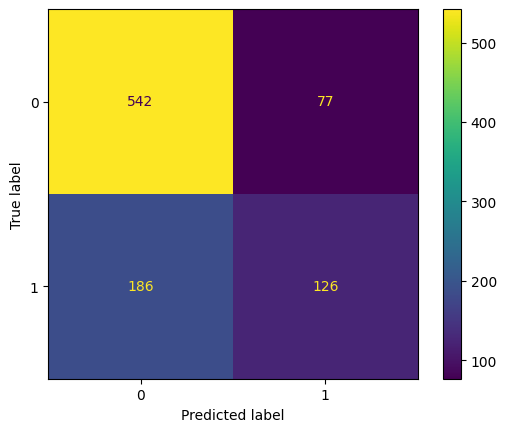

In [14]:
#Test execute

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=LogisticRegression)

print(f"\nFitted model coefs: {mdl.coef_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)



>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.linear_model._logistic.LogisticRegression'>

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.634166   0.65914585 0.64919355]
CV Performance scores std: 0.0103
CV Performance scores average: 0.6475

Fitting model on full training set..
Trained model on 4 features
Finished fitting model. Took 0.0042s

Getting predictions on full training data..
Full prediction time: 0.0002
Accuracy Score (Full) = 0.6464
<<END Initializing & Training Model.

Fitted model coefs: [[-0.03950788  0.42212681 -0.18422917  0.76966289]]

Tuning dict: {'num_ftrs': 4}

Getting predictions for full testing data..
Prediction time: 0.0002
Accuracy: 0.6337271750805585
Precision: [0.68146214 0.41212121]
Recall: [0.84329564 0.21794872]


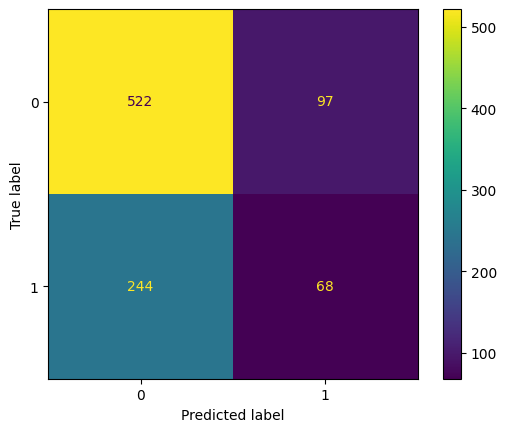

In [15]:
#Test execute with PCA transformed X data

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train_reduced, Y_train, model_class=LogisticRegression)

print(f"\nFitted model coefs: {mdl.coef_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test_reduced, Y_test)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)



>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best params: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best scores: 0.7300822357912798

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.73247381 0.74133763 0.71532258]
CV Performance scores std: 0.0108
CV Performance scores average: 0.7297

Fitting model on full training set..
Trained model on 9 features
Finished fitting model. Took 0.0106s

Getting predictions on full training data..
Full prediction time: 0.0002
Accuracy Score (Full) = 0.7303
<<END Initializing & Training Model.

Fitted model coefs: [[ 0.37729806 -0.41949991  0.73482836  0.62056711 -0.9564353  -0.15893494
  -0.41384317 -0.41435733 -0.04246885]]

Tuning dict: {'hyperparams': {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}, 'num_ftrs': 9}

Getting predictions for full testing data..
Prediction time: 0.0001
Accuracy: 0.7185821697099892
Precision: [0.74552957 0.622549

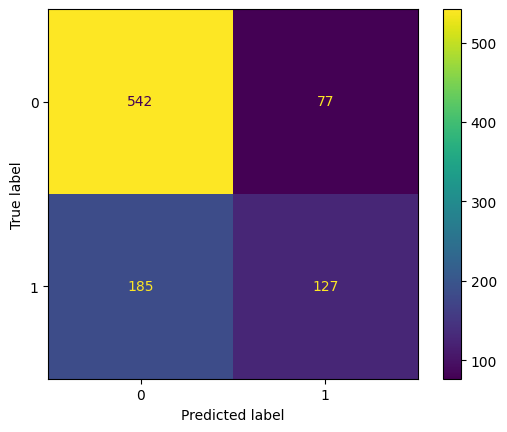

In [16]:
# Test execute with optimizing hyperparameters 

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=LogisticRegression, find_hyperparams=True, 
                                  param_grid = [{'penalty': ['l1'], 'C':[0.1, 1, 10, 100, 1000], 'solver': ['liblinear']},
                                                {'penalty': ['l2'], 'C':[0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear']},]
                                                )

print(f"\nFitted model coefs: {mdl.coef_}")

print(f"\nTuning dict: {tundic}") #smaller C vals == stronger regularization

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)



>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best scores: 0.7308899902339293

Optimizing Feature Inclusion..
	Searching for optimal number of features to include..
		Best: <0.7407304636392781> using <{'n_features_to_select': 2}>
		Found in: 2.1016 s
	Done searching for optimal number of features.
	Selecting N number of features..
	Done selecting features.

Done Optimizing Feature Inclusion.

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.73730862 0.74536664 0.73951613]
CV Performance scores std: 0.0034
CV Performance scores average: 0.7407

Fitting model on full training set..
Trained model on 2 features
Finished fitting model. Took 0.0025s

Getting predictions on full training data..
Full prediction time: 0.0001
Accuracy Score (Full) = 0.7407
<<END Initializing & Training Model.

Fitted model coefs: [[ 0.89663608 -0.

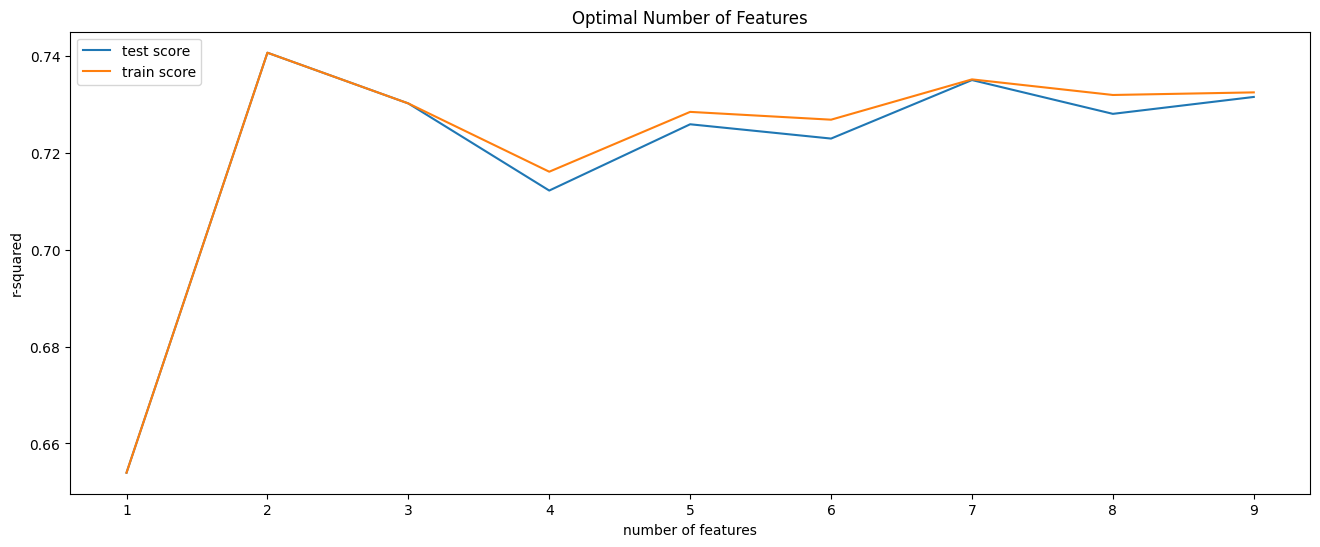

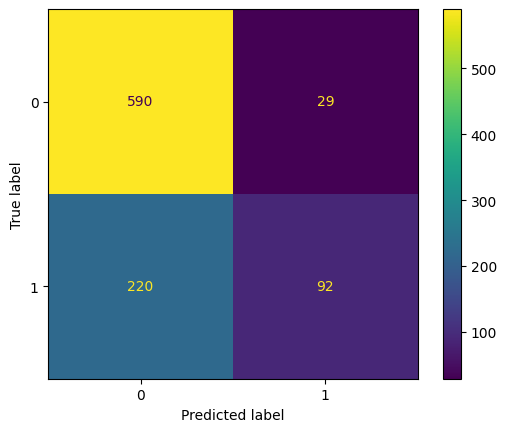

In [17]:
# Test execute with optimizing hyperparameters & Feature Selection

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=LogisticRegression, find_hyperparams=True, 
                                  param_grid = [{'penalty': ['l1'], 'C':[0.1, 1, 10, 100, 1000], 'solver': ['liblinear']},
                                                {'penalty': ['l2'], 'C':[0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear']},],
                                                opt_features=True
                                                )

print(f"\nFitted model coefs: {mdl.coef_}")

print(f"\nTuning dict: {tundic}") #smaller C vals == stronger regularization

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)


# DECISION TREE CLASSIFIER MODELS


>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.81305399 0.81063658 0.80725806]
CV Performance scores std: 0.0024
CV Performance scores average: 0.8103

Fitting model on full training set..
Trained model on 9 features
Finished fitting model. Took 0.005s

Getting predictions on full training data..
Full prediction time: 0.0007
Accuracy Score (Full) = 0.931
<<END Initializing & Training Model.

Fitted model coefs: [0.08176862 0.02018807 0.08959825 0.02438179 0.05424346 0.13974155
 0.33688982 0.17002489 0.08316354]

Tuning dict: {'num_ftrs': 9}

Getting predictions for full testing data..
Prediction time: 0.0003
Accuracy: 0.8045112781954887
Precision: [0.84301413 0.72108844]
Recall: [0.86752827 0.67948718]


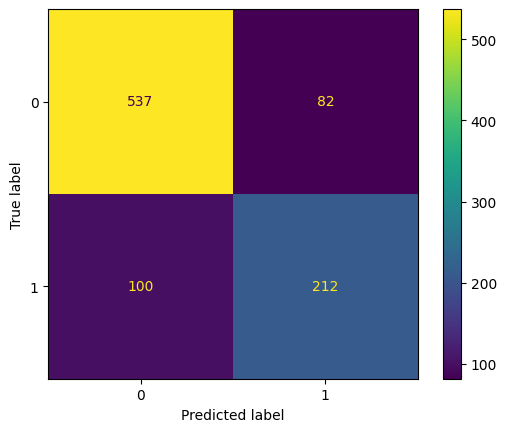

Max tree depth: 21


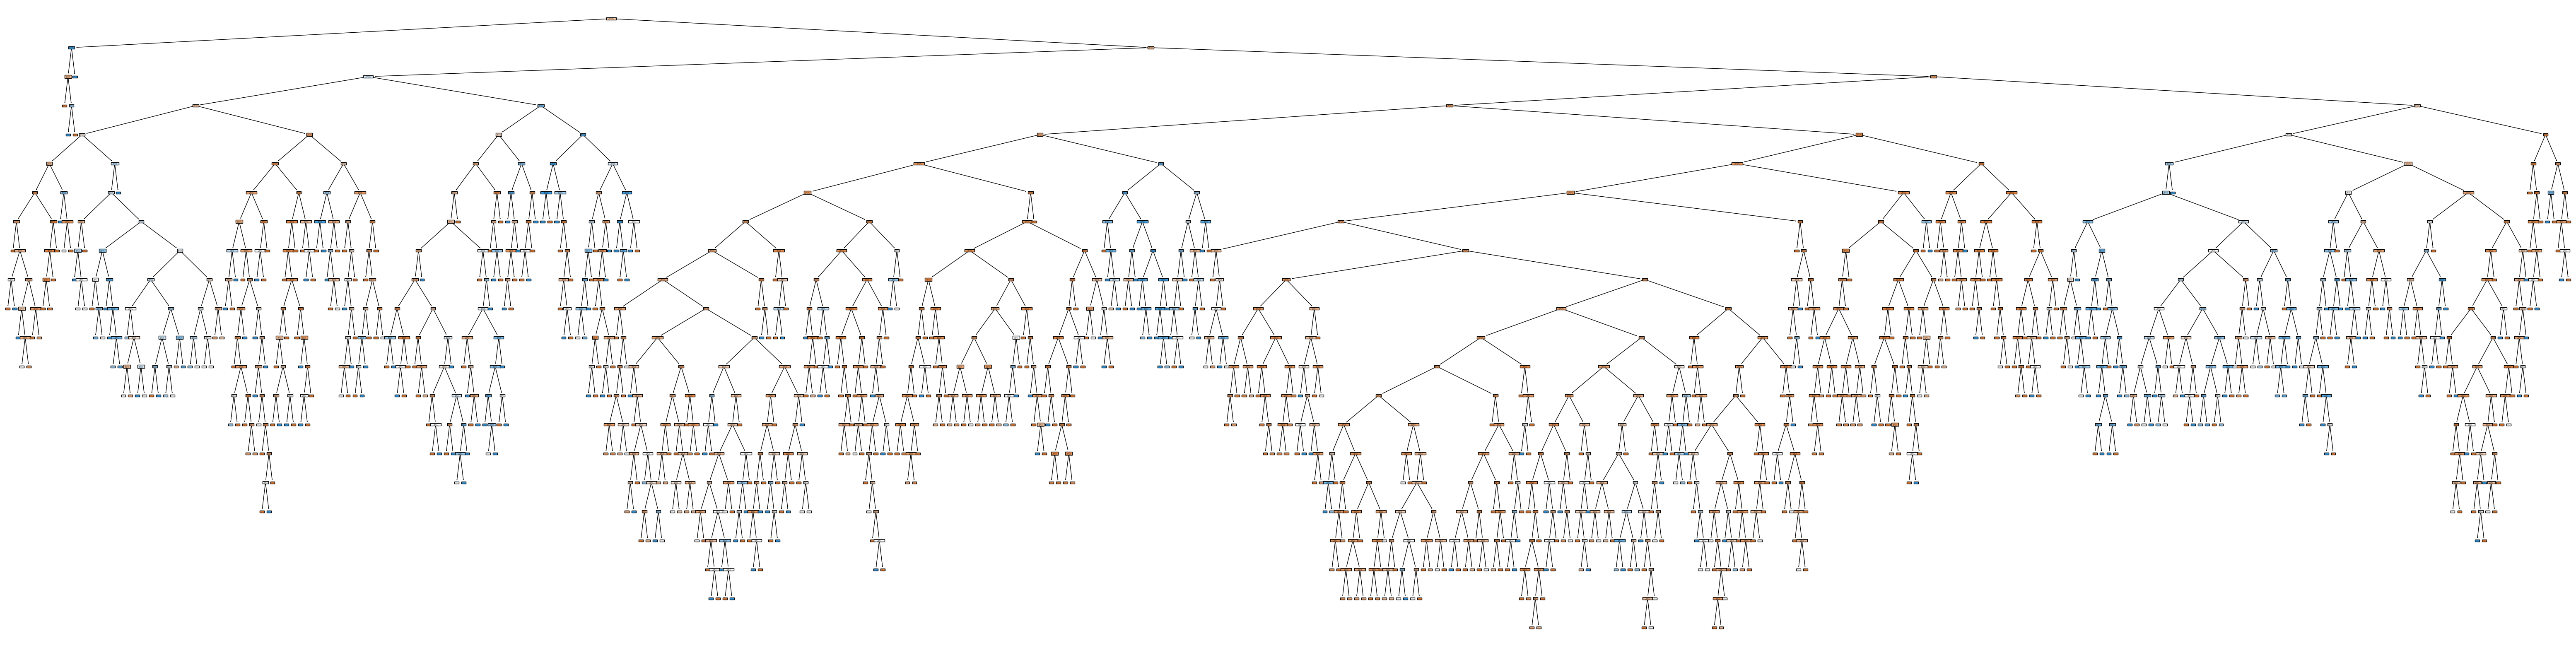

In [18]:
#Test execute

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=DecisionTreeClassifier)

print(f"\nFitted model coefs: {mdl.feature_importances_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)

#visualize Decision Tree?
plt.figure(figsize=(80,20))
plot_tree(mdl, feature_names=training_ftrs, filled=True)

print(f"Max tree depth: {mdl.tree_.max_depth}") #21


>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.7735697  0.78565673 0.75483871]
CV Performance scores std: 0.0127
CV Performance scores average: 0.7714

Fitting model on full training set..
Trained model on 4 features
Finished fitting model. Took 0.0127s

Getting predictions on full training data..
Full prediction time: 0.0008
Accuracy Score (Full) = 0.931
<<END Initializing & Training Model.

Fitted model coefs: [0.11580534 0.38284971 0.12477137 0.37657357]

Tuning dict: {'num_ftrs': 4}

Getting predictions for full testing data..
Prediction time: 0.0002
Accuracy: 0.7841031149301826
Precision: [0.81008902 0.71595331]
Recall: [0.88206785 0.58974359]


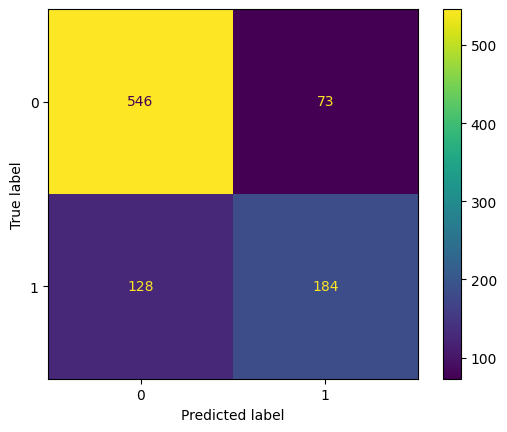

Max tree depth: 29


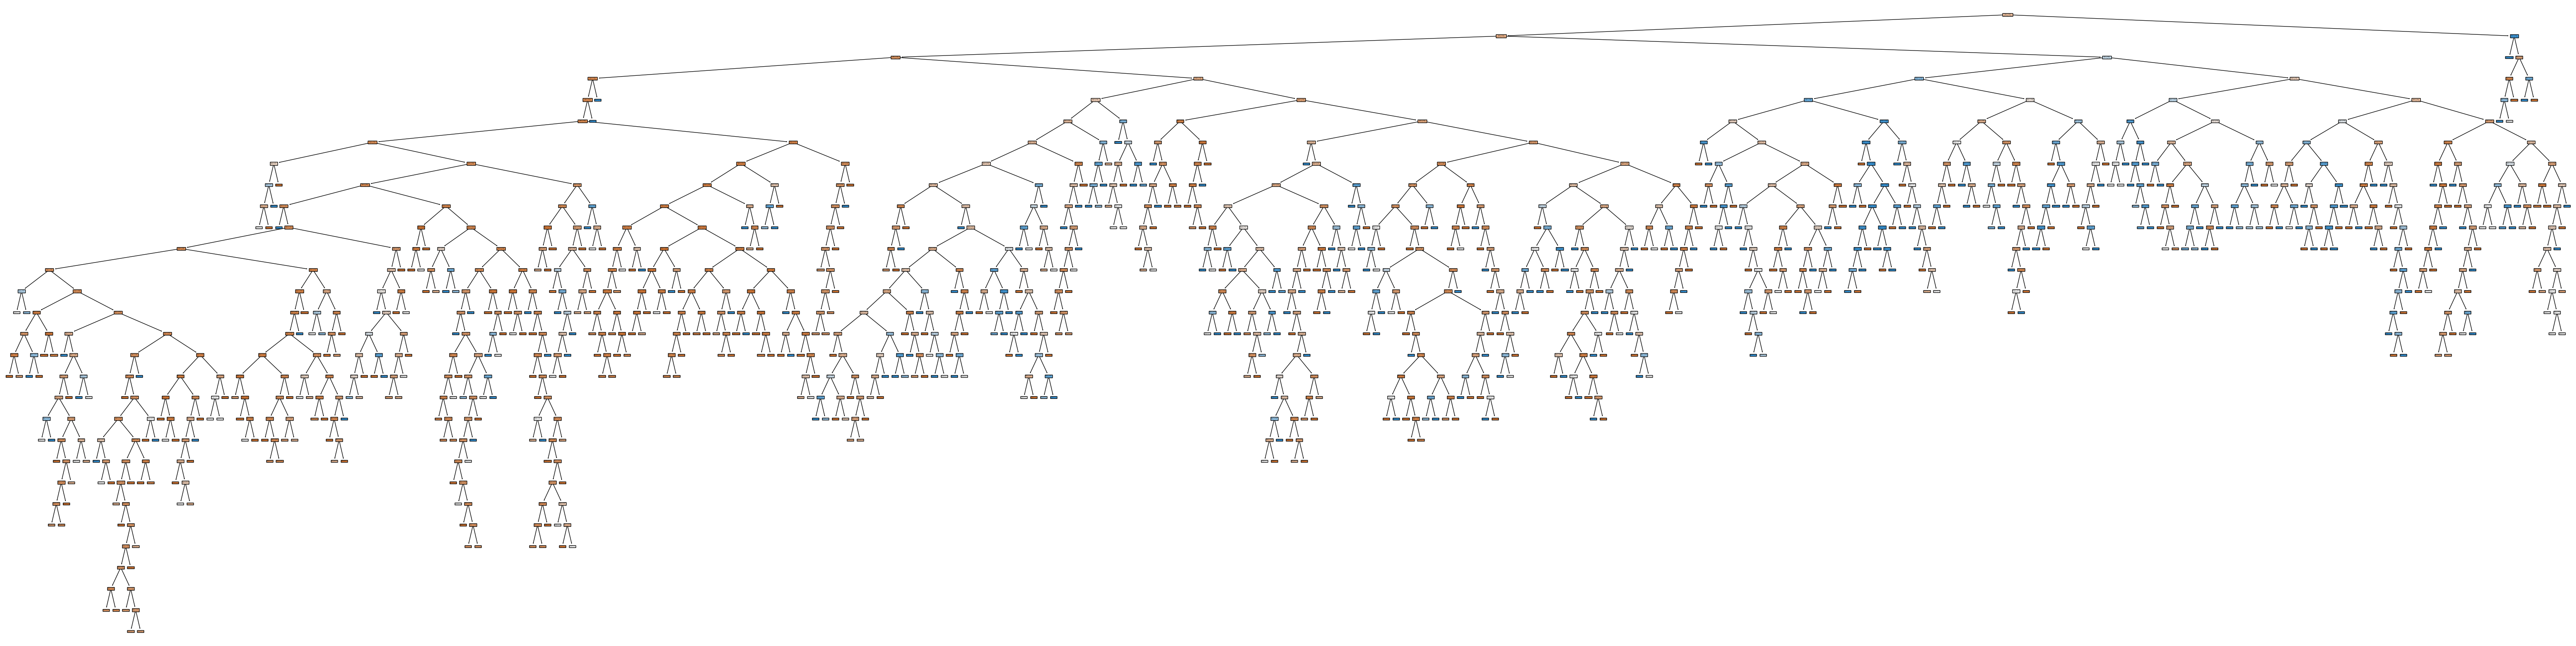

In [19]:
#Test execute with PCA transformed X data

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train_reduced, Y_train, model_class=DecisionTreeClassifier)

print(f"\nFitted model coefs: {mdl.feature_importances_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test_reduced, Y_test)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)

#visualize Decision Tree?
plt.figure(figsize=(80,20))
plot_tree(mdl, filled=True)

print(f"Max tree depth: {mdl.tree_.max_depth}") #29


>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Best params: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 5}
Best scores: 0.8466720998655305

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.84367446 0.85334408 0.82903226]
CV Performance scores std: 0.01
CV Performance scores average: 0.842

Fitting model on full training set..
Trained model on 9 features
Finished fitting model. Took 0.0034s

Getting predictions on full training data..
Full prediction time: 0.0004
Accuracy Score (Full) = 0.8713
<<END Initializing & Training Model.

Fitted model coefs: [0.10497485 0.01701422 0.11634599 0.0097046  0.05721608 0.06371857
 0.36269906 0.23141209 0.03691453]

Tuning dict: {'hyperparams': {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 5}, 'num_ftrs': 9}

Getting predictions for full testing data..
Prediction time: 0.0002
Accuracy: 0.8345864661654135
Precision: [0.8454680

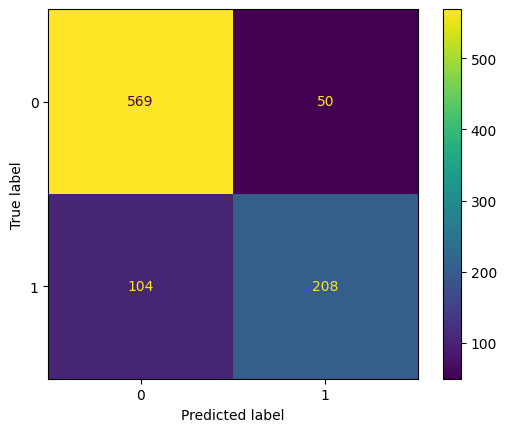

Max tree depth: 8


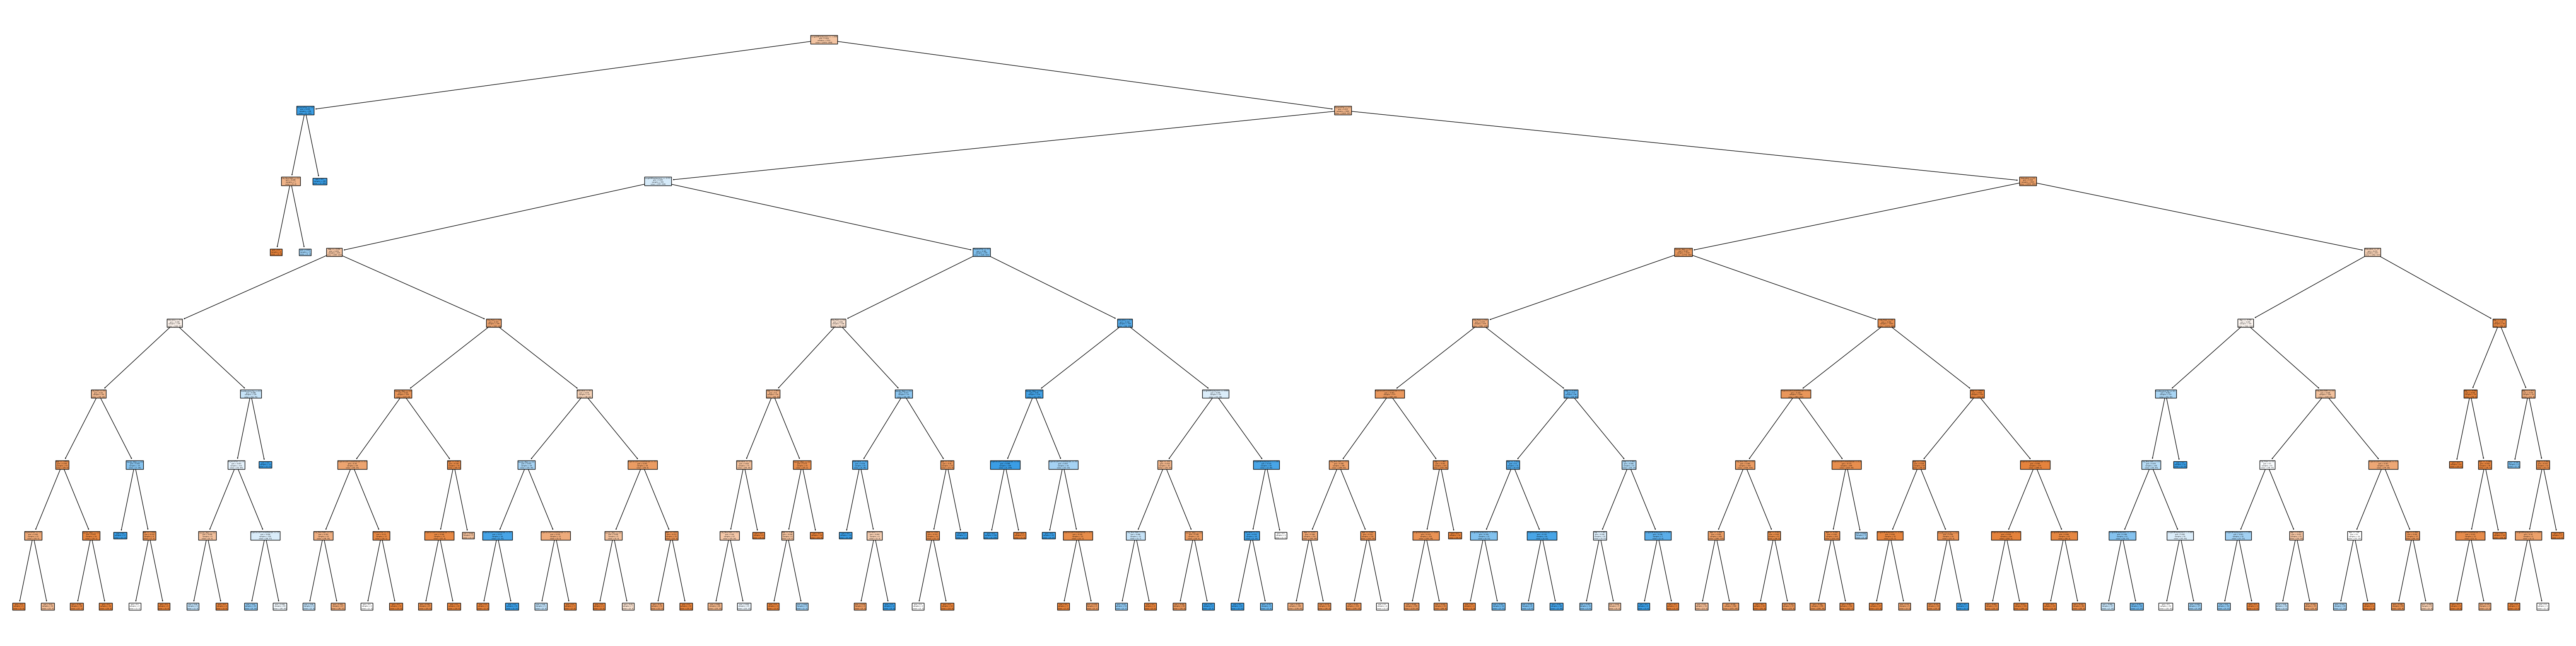

In [20]:
# Test execute with optimizing hyperparameters 

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=DecisionTreeClassifier, find_hyperparams=True, 
                                  param_grid = [{'criterion': ['gini', 'entropy'], 'min_samples_split':[2, 5, 10],'max_depth':[2, 4, 6, 8, 10, 12, 14, 16, 18, 22]}]
                                                )

print(f"\nFitted model coefs: {mdl.feature_importances_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)

#visualize Decision Tree
plt.figure(figsize=(80,20))
plot_tree(mdl, feature_names=training_ftrs, filled=True)

print(f"Max tree depth: {mdl.tree_.max_depth}") #8


>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Best params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}
Best scores: 0.7728462062403668

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.78243352 0.77921031 0.75967742]
CV Performance scores std: 0.0101
CV Performance scores average: 0.7738

Fitting model on full training set..
Trained model on 4 features
Finished fitting model. Took 0.0052s

Getting predictions on full training data..
Full prediction time: 0.0003
Accuracy Score (Full) = 0.7902
<<END Initializing & Training Model.

Fitted model coefs: [0.         0.52597907 0.0278158  0.44620513]

Tuning dict: {'hyperparams': {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}, 'num_ftrs': 4}

Getting predictions for full testing data..
Prediction time: 0.0002
Accuracy: 0.7798066595059077
Precision: [0.776      0.79558011]
Recall: [0.94022617 0.46153846]


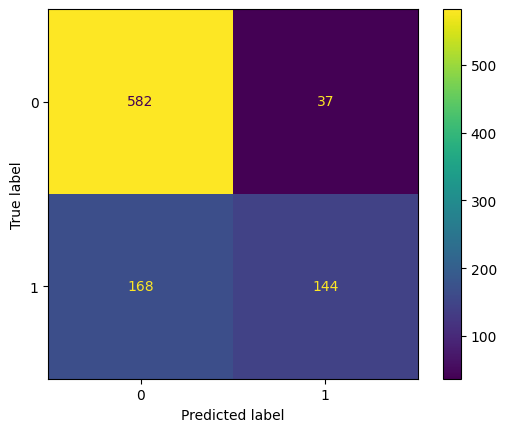

Max tree depth: 4


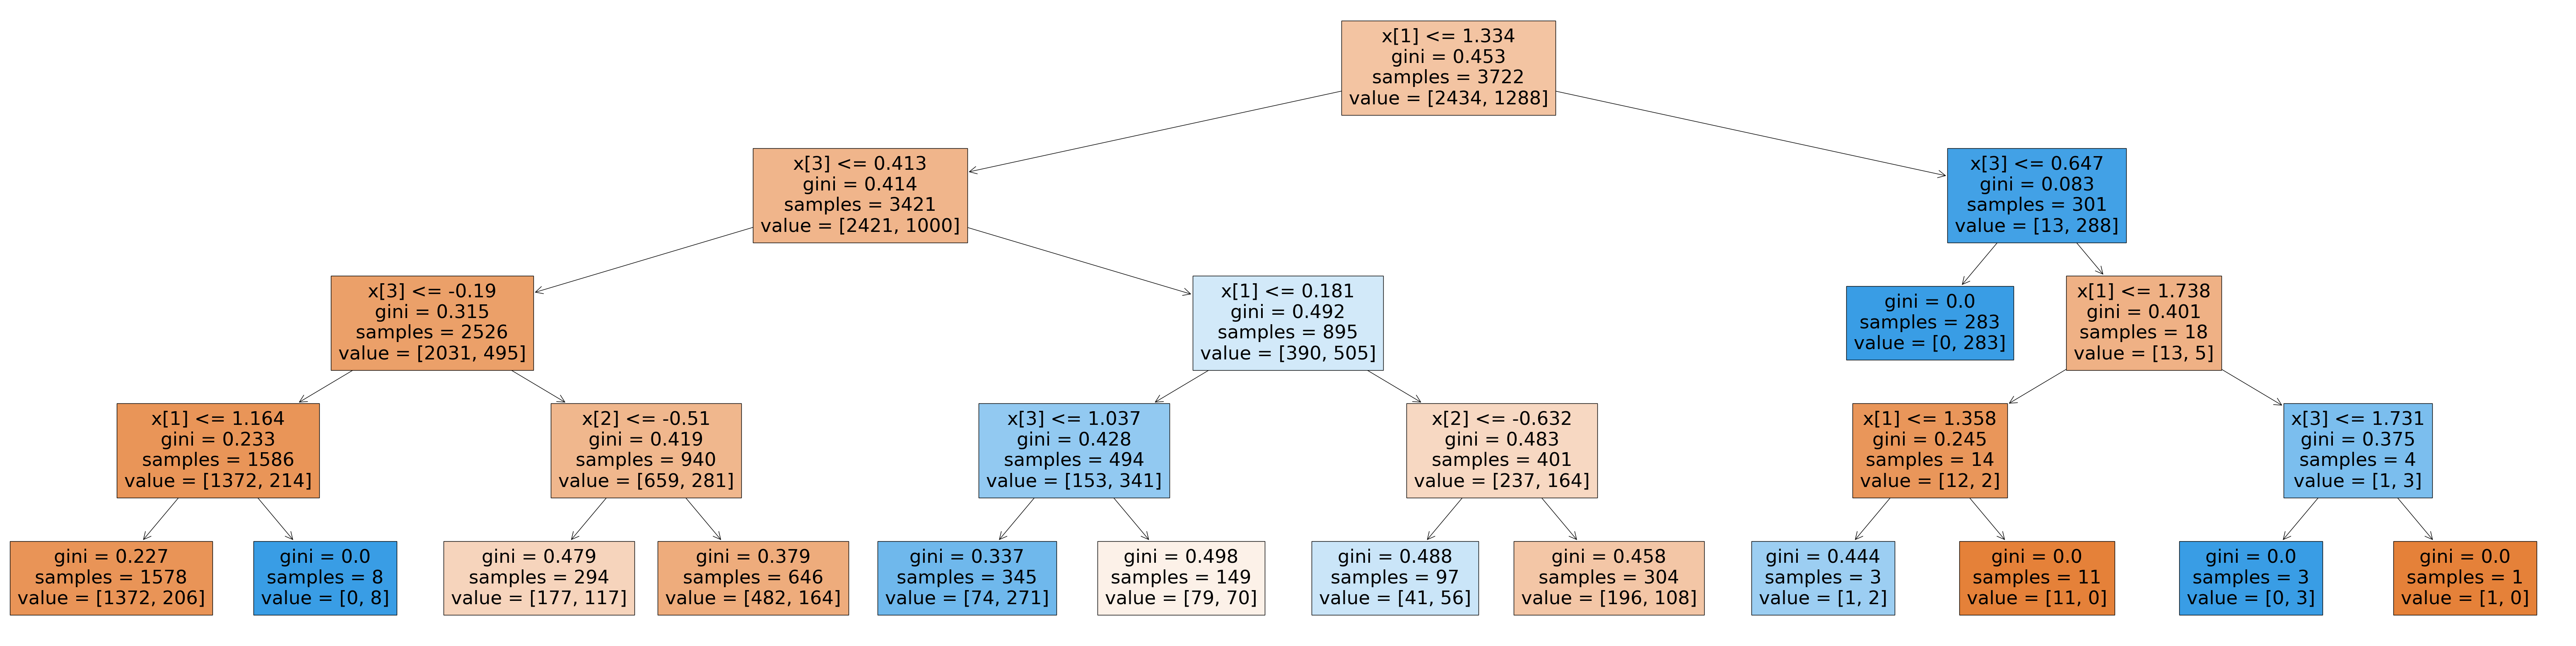

In [21]:
# Test execute with optimizing hyperparameters with PCA transformed X data

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train_reduced, Y_train, model_class=DecisionTreeClassifier, find_hyperparams=True, 
                                  param_grid = [{'criterion': ['gini', 'entropy'], 'min_samples_split':[2, 5, 10],'max_depth':[2, 4, 6, 8, 10, 12, 14, 16, 18, 22]}]
                                                )

print(f"\nFitted model coefs: {mdl.feature_importances_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test_reduced, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)

#visualize Decision Tree
plt.figure(figsize=(80,20))
plot_tree(mdl, filled=True)

print(f"Max tree depth: {mdl.tree_.max_depth}") #8


>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Best params: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 2}
Best scores: 0.8428868542919637

Optimizing Feature Inclusion..
	Searching for optimal number of features to include..
		Best: <0.8460483221127602> using <{'n_features_to_select': 7}>
		Found in: 0.1288 s
	Done searching for optimal number of features.
	Selecting N number of features..
	Done selecting features.

Done Optimizing Feature Inclusion.

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.83883965 0.85173247 0.83790323]
CV Performance scores std: 0.0063
CV Performance scores average: 0.8428

Fitting model on full training set..
Trained model on 7 features
Finished fitting model. Took 0.0025s

Getting predictions on full training data..
Full prediction time: 0.0003
Accuracy Score (Full) = 0.8528
<<END Initializing & Training Model.

Fitted model coefs: [0.116

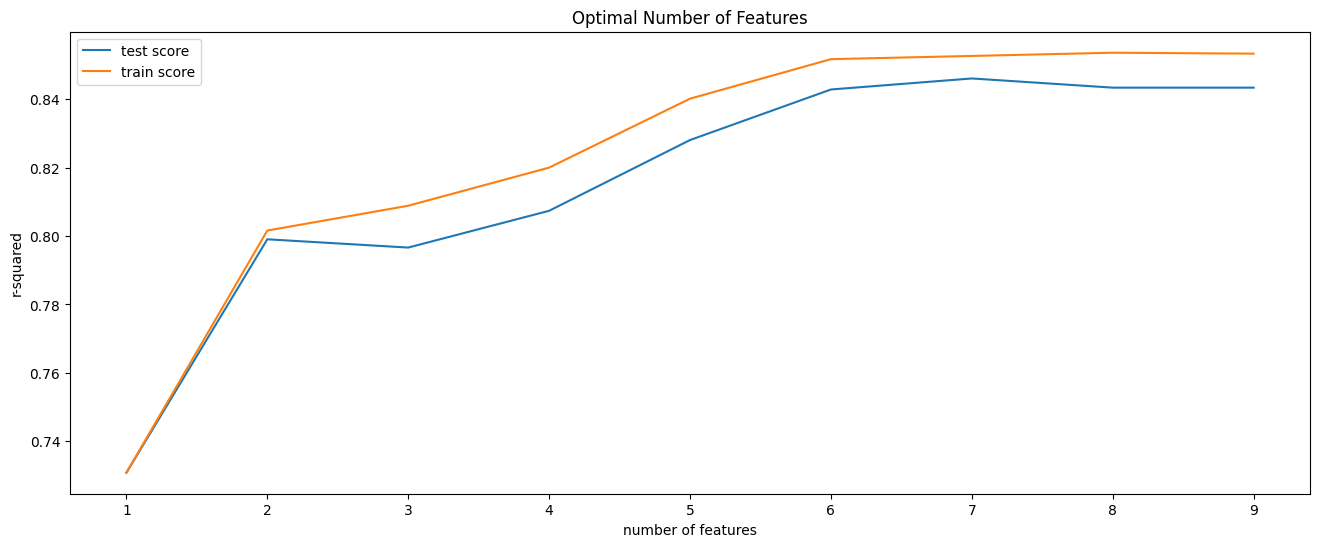

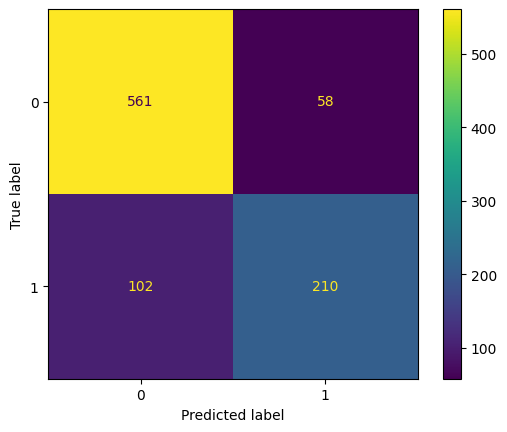

Max tree depth: 6


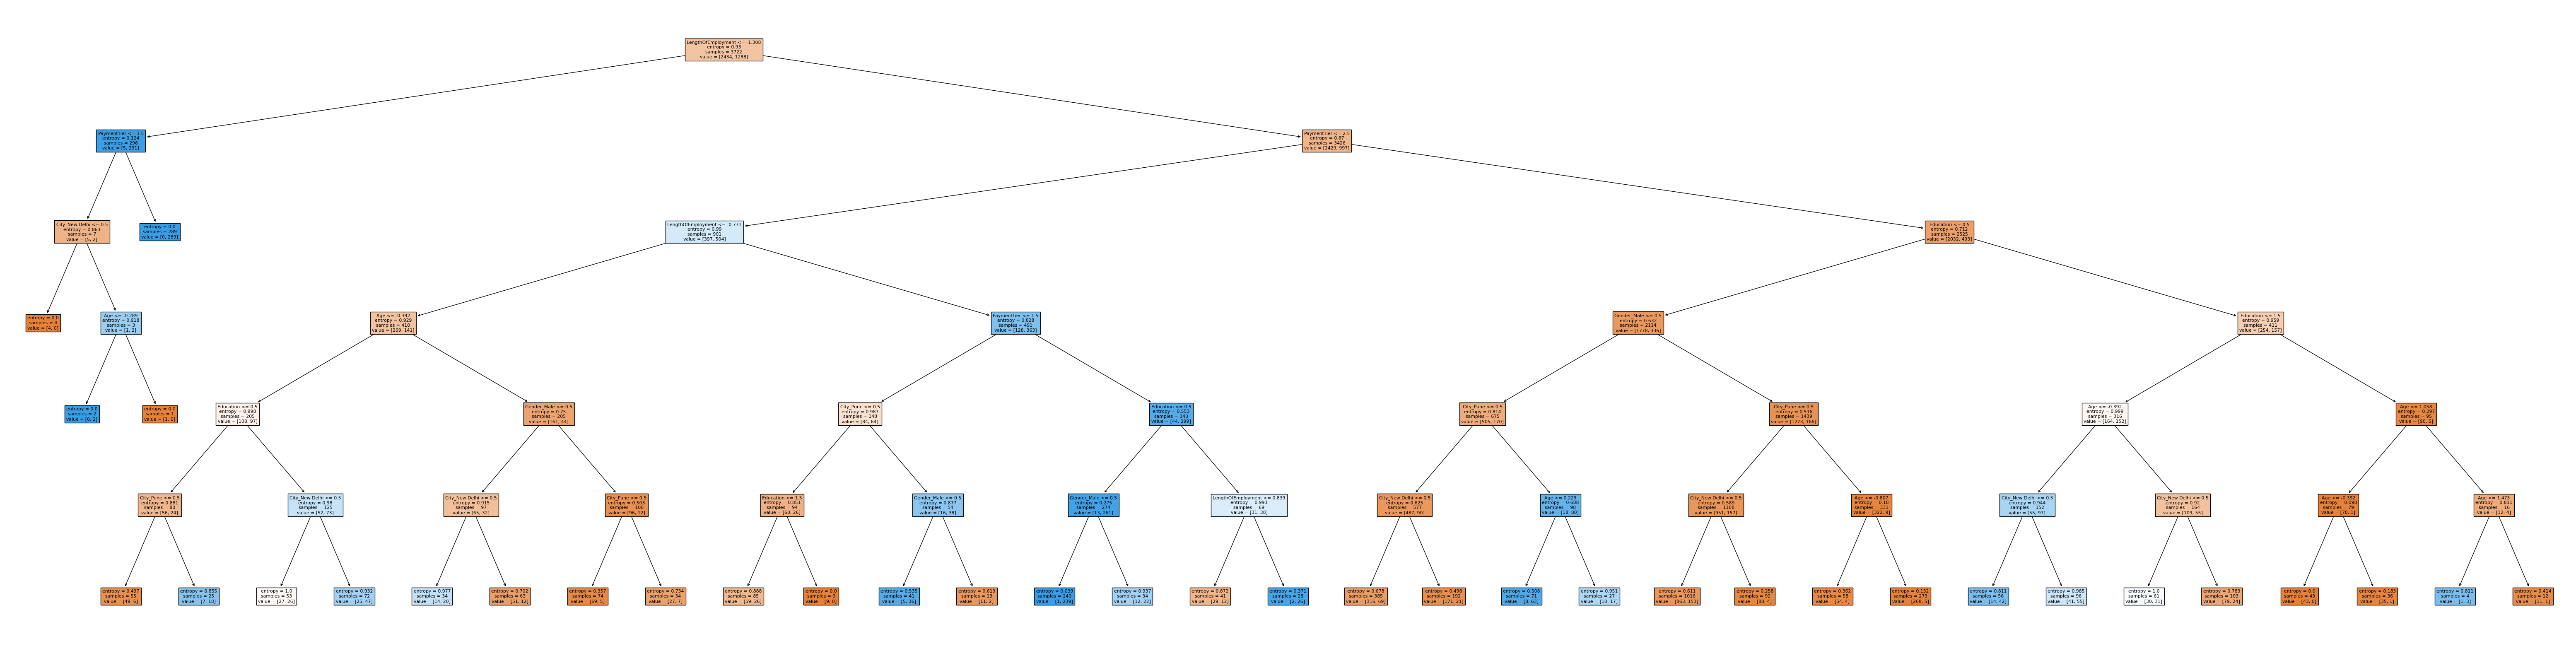

In [22]:
# Test execute with optimizing hyperparameters & Feature Selection

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=DecisionTreeClassifier, find_hyperparams=True, 
                                  param_grid = [{'criterion': ['gini', 'entropy'], 'min_samples_split':[2, 5, 10], 'max_depth':[2, 4, 6, 8, 10, 12, 14, 16, 18, 22]}],
                                                opt_features=True)

print(f"\nFitted model coefs: {mdl.feature_importances_}")

print(f"\nTuning dict: {tundic}") #opted to drop 'EverBenched_Yes' and 'ExperienceInCurrentDomain'

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)

#visualize Decision Tree
plt.figure(figsize=(80,20))
plot_tree(mdl, feature_names=training_ftrs, filled=True) 

print(f"Max tree depth: {mdl.tree_.max_depth}") #6

DID LAST DTC MODEL REDUCE RECALL ON CLASS 1? (MINORITY)

# RANDOM FOREST CLASSIFIER MODELS


>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.83400483 0.83481064 0.81532258]
CV Performance scores std: 0.009
CV Performance scores average: 0.828

Fitting model on full training set..
Trained model on 9 features
Finished fitting model. Took 0.2927s

Getting predictions on full training data..
Full prediction time: 0.0461
Accuracy Score (Full) = 0.931
<<END Initializing & Training Model.

Fitted model coefs: [0.0965452  0.0258951  0.08375282 0.01959878 0.0875933  0.16180528
 0.32308847 0.11532881 0.08639223]

Tuning dict: {'num_ftrs': 9}

Getting predictions for full testing data..
Prediction time: 0.0216
Accuracy: 0.8227712137486574
Precision: [0.8470948  0.76534296]
Recall: [0.89499192 0.67948718]


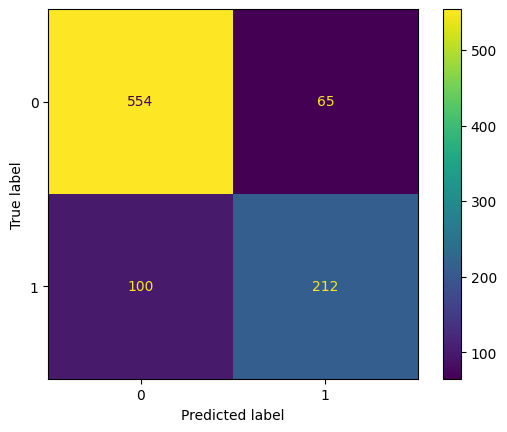

In [23]:
#Test execute

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=RandomForestClassifier)

print(f"\nFitted model coefs: {mdl.feature_importances_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)


#visualize Decision Trees ?
# plt.figure(figsize=(80,20))
# plot_tree(mdl, feature_names=training_ftrs, filled=True) 

# print(f"Max tree depth: {mdl.tree_.max_depth}") #6


>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best scores: 0.8463201379425676

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.85334408 0.85092667 0.83145161]
CV Performance scores std: 0.0098
CV Performance scores average: 0.8452

Fitting model on full training set..
Trained model on 9 features
Finished fitting model. Took 0.1413s

Getting predictions on full training data..
Full prediction time: 0.022
Accuracy Score (Full) = 0.8941
<<END Initializing & Training Model.

Fitted model coefs: [0.11330821 0.02257942 0.11001884 0.01697052 0.10679465 0.09029943
 0.34252969 0.14045136 0.05704788]

Tuning dict: {'hyperparams': {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}, 'num_ftrs': 9}

Getting predictions for full testing data..
Prediction time: 0.0108
Acc

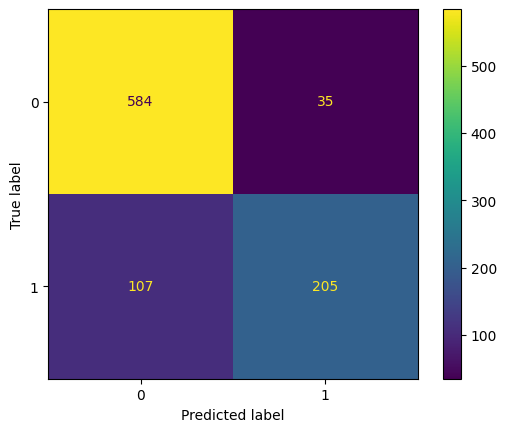

In [33]:
# Test execute with optimizing hyperparameters 

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=RandomForestClassifier, find_hyperparams=True, 
                                  param_grid = [{'criterion': ['gini', 'entropy'], 'min_samples_split':[2, 5, 10], 'n_estimators':[10, 50, 100, 200], 'max_depth':[2, 4, 6, 8, 10, 12, 14, 16, 18, 22]}]
                                                )

print(f"\nFitted model coefs: {mdl.feature_importances_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)




>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best params: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 10}
Best scores: 0.798265721167181

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.81063658 0.80660757 0.77983871]
CV Performance scores std: 0.0137
CV Performance scores average: 0.799

Fitting model on full training set..
Trained model on 4 features
Finished fitting model. Took 0.5203s

Getting predictions on full training data..
Full prediction time: 0.0366
Accuracy Score (Full) = 0.8428
<<END Initializing & Training Model.

Fitted model coefs: [0.0755365  0.44266929 0.08625197 0.39554224]

Tuning dict: {'hyperparams': {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 10}, 'num_ftrs': 4}

Getting predictions for full testing data..
Prediction time: 0.0168
Accuracy: 0.7969924812030075
Precision: [0.79211957 0.81538462]
Recall: [0.94184168 0.50961538]


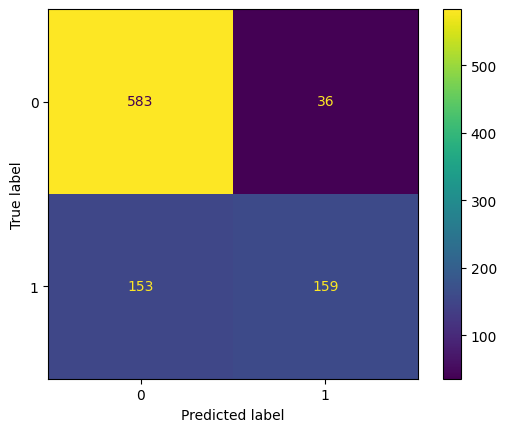

In [25]:
# Test execute with optimizing hyperparameters with PCA transformed X data

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train_reduced, Y_train, model_class=RandomForestClassifier, find_hyperparams=True, 
                                  param_grid = [{'criterion': ['gini', 'entropy'], 'min_samples_split':[2, 5, 10], 'n_estimators':[10, 50, 100, 200], 'max_depth':[2, 4, 6, 8, 10, 12, 14, 16, 18, 22]}]
                                                )

print(f"\nFitted model coefs: {mdl.feature_importances_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test_reduced, Y_test)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)




>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best params: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 100}
Best scores: 0.8496125449996951

Optimizing Feature Inclusion..
	Searching for optimal number of features to include..
		Best: <0.8495401297947373> using <{'n_features_to_select': 8}>
		Found in: 9.6204 s
	Done searching for optimal number of features.
	Selecting N number of features..
	Done selecting features.

Done Optimizing Feature Inclusion.

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.85012087 0.86059629 0.83790323]
CV Performance scores std: 0.0093
CV Performance scores average: 0.8495

Fitting model on full training set..
Trained model on 8 features
Finished fitting model. Took 0.2483s

Getting predictions on full training data..
Full prediction time: 0.0519
Accuracy Score (Full) = 0.8855
<<END Initializing & Training Model.

Fit

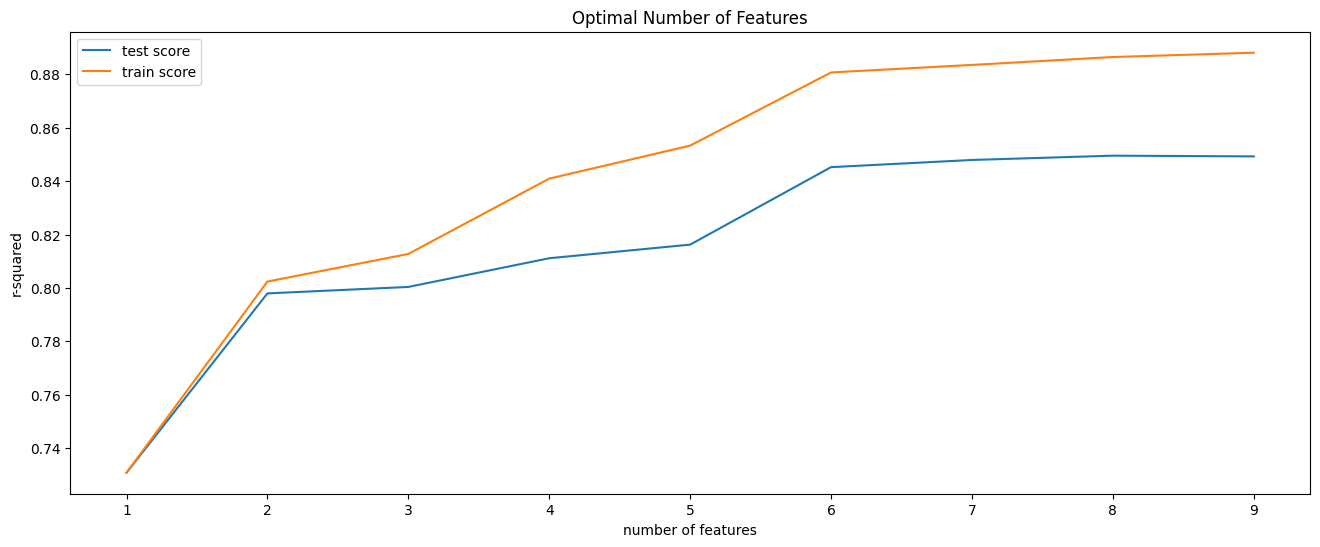

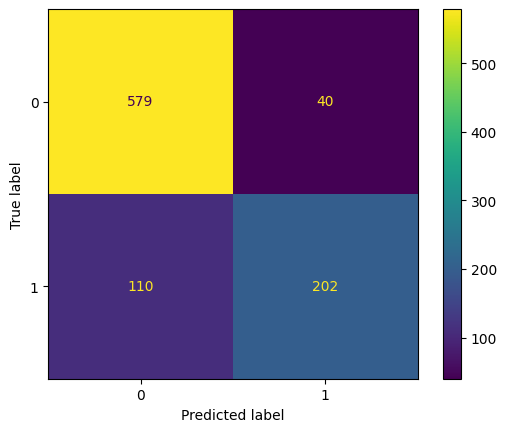

In [35]:
# Test execute with optimizing hyperparameters & Feature Selection

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=RandomForestClassifier, find_hyperparams=True, 
                                  param_grid = [{'criterion': ['gini', 'entropy'], 'min_samples_split':[2, 5, 10], 'n_estimators':[10, 50, 100, 200], 'max_depth':[2, 4, 6, 8, 10, 12, 14, 16, 18, 22]}],
                                                opt_features=True
                                                )

print(f"\nFitted model coefs: {mdl.feature_importances_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)



# SUPPORT VECTOR CLASSIFIER MODELS


>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.svm._classes.SVC'>

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.73005641 0.74294923 0.71129032]
CV Performance scores std: 0.013
CV Performance scores average: 0.7281

Fitting model on full training set..
Trained model on 9 features
Finished fitting model. Took 2.4198s

Getting predictions on full training data..
Full prediction time: 0.1924
Accuracy Score (Full) = 0.7284
<<END Initializing & Training Model.

Fitted model coefs: [1. 1.]

Tuning dict: {'num_ftrs': 9}

Getting predictions for full testing data..
Prediction time: 0.0477
Accuracy: 0.715359828141783
Precision: [0.73790323 0.62566845]
Recall: [0.88691438 0.375     ]


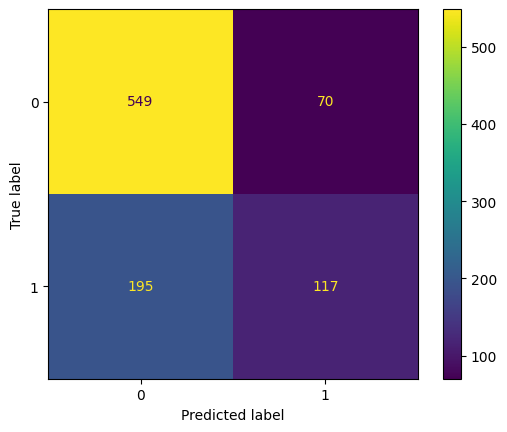

In [27]:
#Test execute with Linear kernel

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=SVC, params={'kernel':'linear', 'probability':True})

print(f"\nFitted model coefs: {mdl.class_weight_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)



>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.svm._classes.SVC'>

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.78243352 0.79935536 0.79112903]
CV Performance scores std: 0.0069
CV Performance scores average: 0.791

Fitting model on full training set..
Trained model on 9 features
Finished fitting model. Took 2.6276s

Getting predictions on full training data..
Full prediction time: 0.8076
Accuracy Score (Full) = 0.8098
<<END Initializing & Training Model.

Fitted model coefs: [1. 1.]

Tuning dict: {'num_ftrs': 9}

Getting predictions for full testing data..
Prediction time: 0.1849
Accuracy: 0.7808807733619764
Precision: [0.78308322 0.77272727]
Recall: [0.9273021  0.49038462]


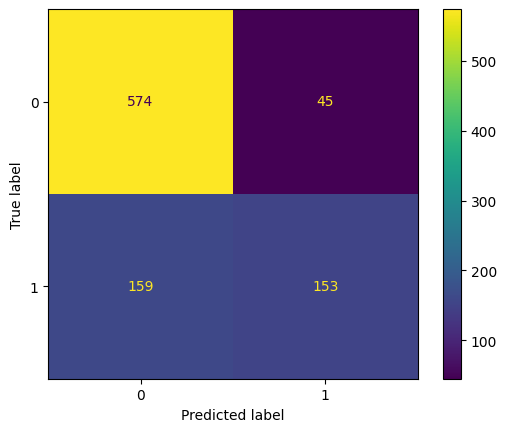

In [28]:
#Test execute with Rbf kernel

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=SVC, params={'kernel':'rbf', 'probability':True})

print(f"\nFitted model coefs: {mdl.class_weight_}")

print(f"\nTuning dict: {tundic}")

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)



>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.svm._classes.SVC'>
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
Best scores: 0.8377470393893751

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.83561644 0.85334408 0.82580645]
CV Performance scores std: 0.0114
CV Performance scores average: 0.8383

Fitting model on full training set..
Trained model on 9 features
Finished fitting model. Took 2.87s

Getting predictions on full training data..
Full prediction time: 0.5663
Accuracy Score (Full) = 0.8616
<<END Initializing & Training Model.

Fitted model coefs: [1. 1.]

Tuning dict: {'hyperparams': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}, 'num_ftrs': 9}

Getting predictions for full testing data..
Prediction time: 0.168
Accuracy: 0.8259935553168636
Precision: [0.82503556 0.82894737]
Recall: [0.93699515 0.60576923]


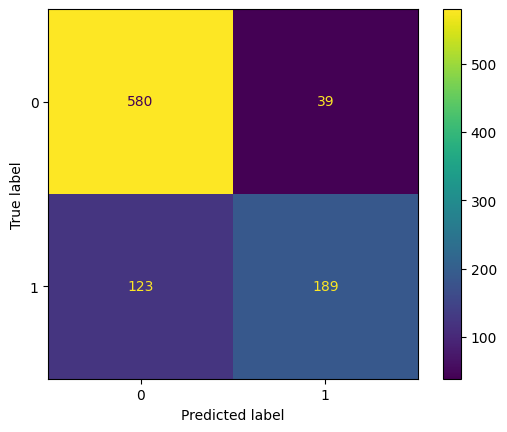

In [29]:
# Test execute with optimizing hyperparameters 

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=SVC, find_hyperparams=True, 
                                  param_grid = [{'kernel': ['linear', 'rbf'], 'probability':[True], 'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001]}]
                                                )

print(f"\nFitted model coefs: {mdl.class_weight_}")

print(f"\nTuning dict: {tundic}") #smaller C vals == stronger regularization

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)



>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.svm._classes.SVC'>
Best params: {'C': 10, 'gamma': 0.001, 'kernel': 'linear', 'probability': True}
Best scores: 0.7281976927386418

Optimizing Feature Inclusion..
	Searching for optimal number of features to include..
		Best: <0.7307850935336574> using <{'n_features_to_select': 8}>
		Found in: 50.5062 s
	Done searching for optimal number of features.
	Selecting N number of features..
	Done selecting features.

Done Optimizing Feature Inclusion.

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.73408541 0.74536664 0.71290323]
CV Performance scores std: 0.0135
CV Performance scores average: 0.7308

Fitting model on full training set..
Trained model on 8 features
Finished fitting model. Took 3.897s

Getting predictions on full training data..
Full prediction time: 0.2139
Accuracy Score (Full) = 0.7297
<<END Initializing & Training Model.

Fitted model coefs: [1. 1.]

Tuning dict: {'

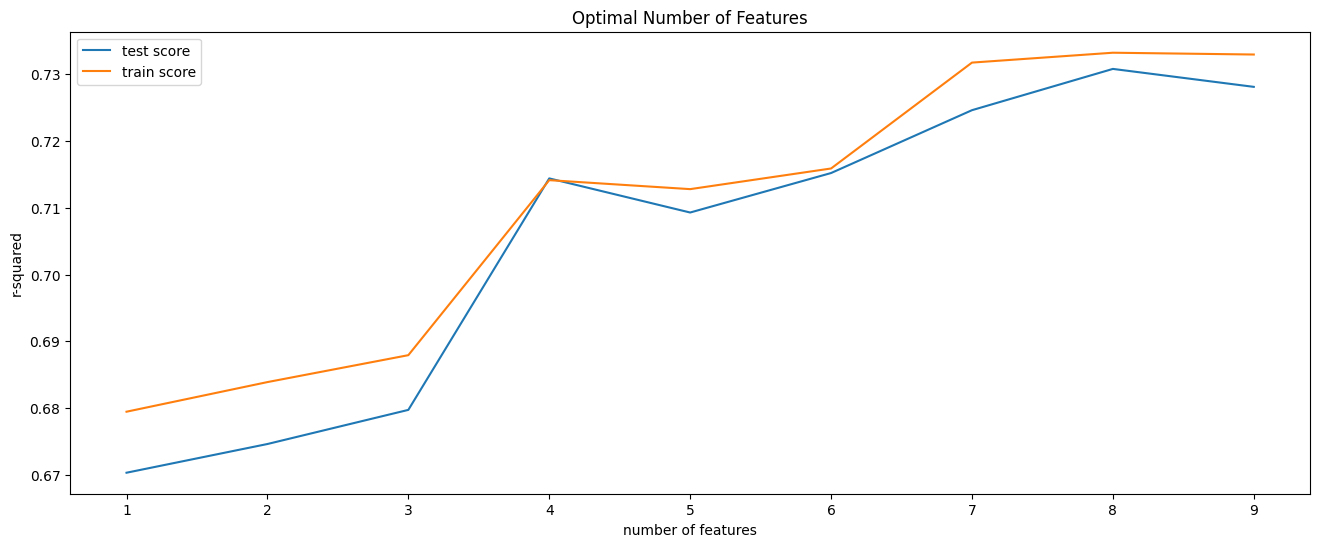

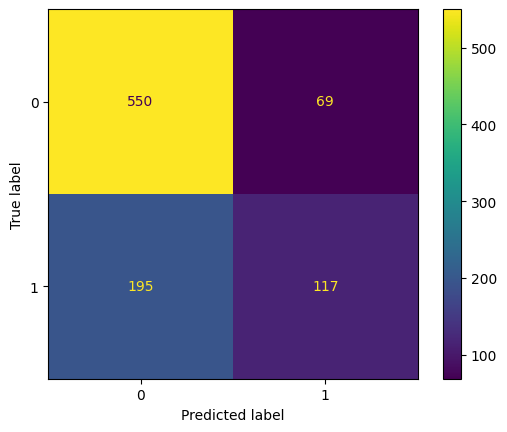

In [30]:
# Test execute with optimizing hyperparameters & Feature Selection -- RFE only works for linear models

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=SVC, find_hyperparams=True, 
                                  param_grid = [{'kernel': ['linear'], 'probability':[True], 'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001]}],
                                                opt_features=True
                                                )

print(f"\nFitted model coefs: {mdl.class_weight_}")

print(f"\nTuning dict: {tundic}") #smaller C vals == stronger regularization

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)




>>BEGIN Initializing & Training model..
Making model: <class 'sklearn.svm._classes.SVC'>
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}
Best scores: 0.7284669442195248

Optimizing Feature Inclusion..
	Searching for optimal number of features to include..
		Best: <0.7307850935336574> using <{'n_features_to_select': 8}>
		Found in: 51.7383 s
	Done searching for optimal number of features.
	Selecting N number of features..
	Done selecting features.

Done Optimizing Feature Inclusion.

Starting CV fitting & evaluations..
CV Performance Analysis scores across 3 folds: [0.73408541 0.74536664 0.71290323]
CV Performance scores std: 0.0135
CV Performance scores average: 0.7308

Fitting model on full training set..
Trained model on 8 features
Finished fitting model. Took 4.1509s

Getting predictions on full training data..
Full prediction time: 0.1646
Accuracy Score (Full) = 0.7297
<<END Initializing & Training Model.

Fitted model coefs: [1. 1.]

Tuning dict: {'h

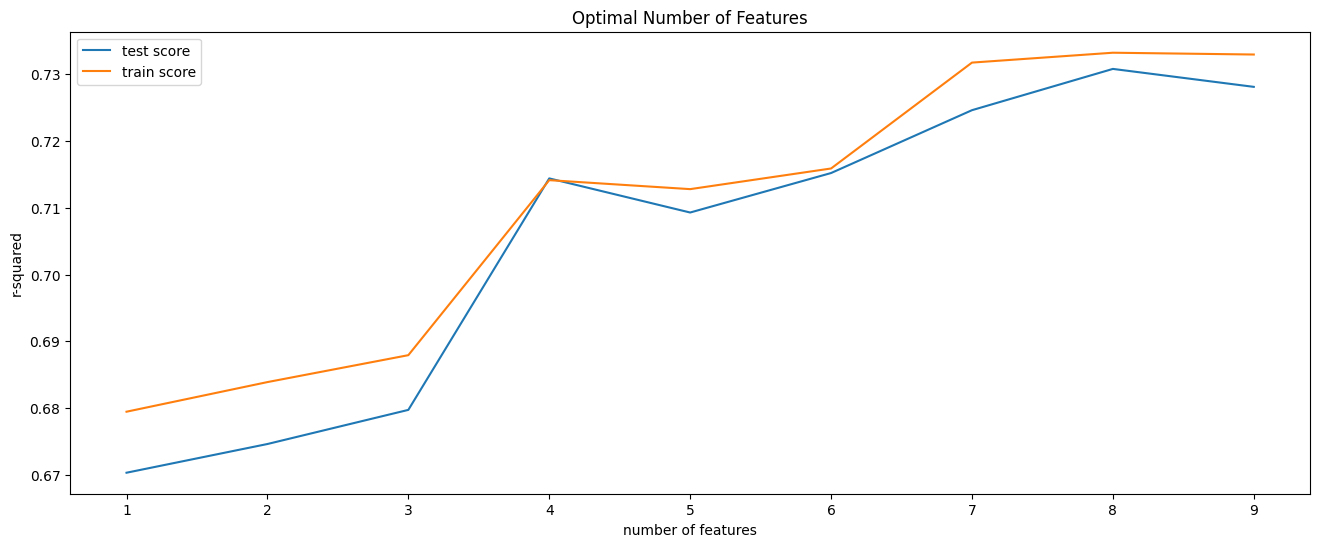

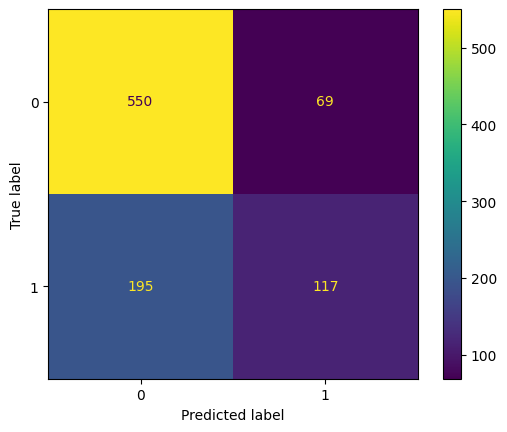

In [31]:
# Test execute with optimizing hyperparameters & Feature Selection -- RFE only works for linear models

mdl, training_ftrs, rtrndf, tundic = init_Model(X_train, Y_train, model_class=SVC, find_hyperparams=True, 
                                  param_grid = [{'kernel': ['linear'], 'probability':[True], 'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001]}],
                                                opt_features=True
                                                )

print(f"\nFitted model coefs: {mdl.class_weight_}")

print(f"\nTuning dict: {tundic}") #smaller C vals == stronger regularization

y_p, y_proba, p_time = model_predict(mdl, X_test, Y_test, ftrs=training_ftrs)

scores_d = get_scores(mdl, np.ravel(Y_test.to_numpy()), y_p)



# DEPRECATED...

In [ ]:
# def make_model_decorator(make_func):
#     signature = inspect.signature(make_func)
#     default_kwargs = { kw: val.default for kw, val in signature.parameters.items() if val.default != inspect.Signature.empty }
    
#     @functools.wraps(make_func)
#     def wrapper(*args, **kwargs):
#         kwargs = default_kwargs | kwargs

#         print(f"Args: {args}")
#         print(f"Kwargs: {kwargs}")
        
#         #unpack args & kwargs
#         x=args[0]
#         y=args[1]
#         optimize = kwargs['find_hyperparams']
#         model_func = kwargs['model']
#         param_grid = kwargs['param_grid']
#         cv_val = kwargs['cv']
        
#         make_func(*args, **kwargs)
        
#         model = model_func(random_state=0)
        
#         if optimize:
#             model = HalvingGridSearchCV(model, param_grid, cv=cv_val, refit=True)
#             model.fit(x, y)
#             fit_time = model.refit_time_
            
#             print(f"Best params: {model.best_params_}")
#             print(f"Best scores: {model.best_score_}")
#             model = model.best_estimator_
#         else:
#             start_time = time.perf_counter() #time.time() ?
#             model.fit(x, y)
#             fit_time = time.perf_counter() - start_time
        
#         return model, fit_time #return coef to Train new model in init_model()?
    
#     return wrapper


# def Decorator_optimize(optimize, func):
#     def inner(*args, **kwargs):
#         if optimize:
#             print("Making optimized model..")
#         else:
#             print("Making generic model..")
        
#         func(find_hyperparams=optimize, *args, **kwargs)
        
#     return inner




# def make_model_LogisticRegression(x, y, find_hyperparams=False, max_iter=300):
    
#     def generic():
#         model = LogisticRegression(random_state=0)
#         start_time = time.time()
#         model.fit(x, y)
#         fit_time = time.time() - start_time
        
#         return model, fit_time

#     def optimized(cv=3):
#         param_grid = [
#             {'penalty': ['l1'], 'C':np.linspace(0.1, 1.0, num=5), 'solver': ['liblinear']},
#             {'penalty': ['l2'], 'C':np.linspace(0.1, 1.0, num=5), 'solver': ['newton-cg', 'lbfgs', 'liblinear']},
#         ]
        
#         base_model = LogisticRegression(random_state=0) #max_iter=100 (default)
#         model = HalvingGridSearchCV(base_model, param_grid, cv=cv, refit=True)
#         model.fit(x, y)
#         fit_time = model.refit_time_
        
#         print(f"Best params: {model.best_params_}")
#         print(f"Best scores: {model.best_score_}")
#         model = model.best_estimator_
        
#         return model, fit_time
    
#     if find_hyperparams:
#         return optimized
#     else:
#         return generic


@make_model_decorator #-- to decorate make_LogReg
def make_LogReg(model=LogisticRegression, find_hyperparams=False, param_grid=[
        {'penalty': ['l1'], 'C':np.linspace(0.1, 1.0, num=5), 'solver': ['liblinear']},
        {'penalty': ['l2'], 'C':np.linspace(0.1, 1.0, num=5), 'solver': ['newton-cg', 'lbfgs', 'liblinear']},
    ], cv=3):

    print(f"Making LogReg model.")
    
    def inner(x, y, cv):
        pass

    return inner



@make_model_decorator
def make_model_RandomForest(x, y, find_hyperparams=False):
    pass


@make_model_decorator
def make_model_DTC(x, y, find_hyperparams=False):
    pass


@make_model_decorator
def make_model_KMeans(x, y, find_hyperparams=False):
    pass


@make_model_decorator
def make_model_SVC(x, y, find_hyperparams=False):
    pass


#MAYBE...
def make_model_NB(x, y, find_hyperparams=False):
    pass

In [ ]:
#GENERIC FUNCTIONS

# def dummify_inputs(df, labels):
#     #breakout model input variables into binary columns
#     df = pd.get_dummies(df, prefix=labels, dummy_na=True, columns=labels, drop_first=True, dtype=bool)
    
#     lbls = {}
#     for l in labels:
#         lbls[l] = [lb for lb in df.columns if str(l) in str(lb)]
    
#     full_lst = []
#     for i in lbls.keys():
#         full_lst = full_lst + lbls[i]
    
#     return df, lbls

# def write_to_file(df, file_nm):
#     #print(f"Enter name for {str} CSV file: ")
#     #nm = input()
#     cwd = os.getcwd() #current path
#     cwd += f"\{file_nm}.csv" #adding name of excel file to path
#     df.to_csv(cwd,index=True, header=True)
#     print(f'Done writing {file_nm}.csv')


# def write_to_excel(out_dict, folder, file_nm):
#     cwd = os.getcwd()
#     exp_path = cwd + f"\{folder}"
#     if not os.path.exists(exp_path):
#         os.mkdir(exp_path)
    
#     exp_path += f"\{file_nm}.xlsx"
#     writer = pd.ExcelWriter(exp_path, engine='xlsxwriter')
    
#     for d in out_dict.keys():
#         out_dict[d].to_excel(writer, sheet_name=d)
    
#     writer.save()
#     print(f'Done writing {file_nm}.xlsx')


# def export_plot(img, folder, img_nm, dset=None, subf=None):
#     cwd = os.getcwd()
#     exp_path = cwd + f"\{folder}"
#     if not os.path.exists(exp_path):
#         os.mkdir(exp_path)
    
#     if dset is not None:
#         exp_path += f"\{dset}"
#         if not os.path.exists(exp_path):
#             os.mkdir(exp_path)
#     if subf is not None:
#         exp_path += f"\{subf}"
#         if not os.path.exists(exp_path):
#             os.mkdir(exp_path)
    
#     exp_path += f"\{img_nm}"
#     img.savefig(exp_path)
#     print(f'Done writing fig {img_nm}')